In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
# Load reference data with tumor types
ref_df = pd.read_csv('../cam16_test_reference.csv')
print(f"Reference data: {len(ref_df)} slides")
print(f"Tumor slides: {len(ref_df[ref_df['type']=='Tumor'])}")
print(f"Normal slides: {len(ref_df[ref_df['type']=='Normal'])}")
print()
print("Tumor level distribution:")
print(ref_df[ref_df['type']=='Tumor']['level'].value_counts())
ref_df.head()

Reference data: 129 slides
Tumor slides: 49
Normal slides: 80

Tumor level distribution:
Micro    27
Macro    22
Name: level, dtype: int64


,image_id,type,detail,level
0,test_001,Tumor,IDC,Macro
1,test_002,Tumor,ILC,Macro
2,test_003,Normal,DCIS,None
3,test_004,Tumor,IDC,Micro
4,test_005,Normal,DCIS,None


In [3]:
# Load FROC results (t5 = min_region_tiles=5)
froc_df = pd.read_csv('localization_score_FROC/per_slide_results_t5.csv')
print(f"FROC results: {len(froc_df)} slides")
froc_df.head()

FROC results: 48 slides


,slide,Ht,Wt,n_lesions,TP_at_th0.5,FP_at_th0.5,TP_at_th0.9,FP_at_th0.9
0,test_001,381,366,12,4,19,4,1
1,test_002,840,405,5,4,27,4,3
2,test_004,447,427,3,1,75,0,13
3,test_008,393,471,2,2,134,2,73
4,test_010,794,367,2,1,102,1,17


## 2. Merge and Categorize

In [4]:
# Merge FROC results with reference data
merged_df = froc_df.merge(ref_df, left_on='slide', right_on='image_id', how='left')

# Keep only tumor slides with valid level info
tumor_df = merged_df[(merged_df['type'] == 'Tumor') & (merged_df['level'].isin(['Macro', 'Micro']))].copy()

print(f"Total tumor slides with results: {len(tumor_df)}")
print(f"Macro-metastasis: {len(tumor_df[tumor_df['level']=='Macro'])}")
print(f"Micro-metastasis: {len(tumor_df[tumor_df['level']=='Micro'])}")
print()
tumor_df.head(10)

Total tumor slides with results: 48
Macro-metastasis: 21
Micro-metastasis: 27



,slide,Ht,Wt,n_lesions,TP_at_th0.5,FP_at_th0.5,TP_at_th0.9,FP_at_th0.9,image_id,type,detail,level
0,test_001,381,366,12,4,19,4,1,test_001,Tumor,IDC,Macro
1,test_002,840,405,5,4,27,4,3,test_002,Tumor,ILC,Macro
2,test_004,447,427,3,1,75,0,13,test_004,Tumor,IDC,Micro
3,test_008,393,471,2,2,134,2,73,test_008,Tumor,Ductulolobular,Micro
4,test_010,794,367,2,1,102,1,17,test_010,Tumor,IDC,Micro
5,test_011,846,385,1,0,3,0,1,test_011,Tumor,ILC,Micro
6,test_013,790,317,3,1,5,0,1,test_013,Tumor,IDC,Micro
7,test_016,401,469,20,7,138,6,25,test_016,Tumor,IDC,Macro
8,test_021,975,423,12,7,6,6,0,test_021,Tumor,IDC,Macro
9,test_026,447,419,76,4,5,2,0,test_026,Tumor,Ductulolobular,Macro


## 3. Summary Statistics by Tumor Level

In [5]:
# Calculate sensitivity at two thresholds
tumor_df['sensitivity_th0.5'] = tumor_df['TP_at_th0.5'] / tumor_df['n_lesions']
tumor_df['sensitivity_th0.9'] = tumor_df['TP_at_th0.9'] / tumor_df['n_lesions']

# Group by tumor level
summary = tumor_df.groupby('level').agg({
    'slide': 'count',
    'n_lesions': ['mean', 'std', 'min', 'max', 'sum'],
    'TP_at_th0.5': ['mean', 'std', 'sum'],
    'FP_at_th0.5': ['mean', 'std', 'min', 'max'],
    'TP_at_th0.9': ['mean', 'std', 'sum'],
    'FP_at_th0.9': ['mean', 'std', 'min', 'max'],
    'sensitivity_th0.5': ['mean', 'std', 'min', 'max'],
    'sensitivity_th0.9': ['mean', 'std', 'min', 'max']
})

summary.columns = ['_'.join(col).strip('_') for col in summary.columns.values]
summary

,slide_count,n_lesions_mean,n_lesions_std,n_lesions_min,n_lesions_max,n_lesions_sum,TP_at_th0.5_mean,TP_at_th0.5_std,TP_at_th0.5_sum,FP_at_th0.5_mean,...,FP_at_th0.9_min,FP_at_th0.9_max,sensitivity_th0.5_mean,sensitivity_th0.5_std,sensitivity_th0.5_min,sensitivity_th0.5_max,sensitivity_th0.9_mean,sensitivity_th0.9_std,sensitivity_th0.9_min,sensitivity_th0.9_max
level,,,,,,,,,,,,,,,,,,,,,
Macro,21,22.666667,20.852658,1,77,476,4.809524,2.731649,101,32.857143,...,0,42,0.362297,0.265210,0.052632,1.0,0.332382,0.273753,0.026316,1.0
Micro,27,4.037037,4.090152,1,14,109,1.962963,1.950966,53,74.592593,...,0,73,0.508137,0.315495,0.000000,1.0,0.426904,0.346973,0.000000,1.0


## 4. Overall FROC Metrics by Level

In [6]:
# Calculate overall sensitivity for each level (across all lesions)
for level in ['Macro', 'Micro']:
    subset = tumor_df[tumor_df['level'] == level]
    total_lesions = subset['n_lesions'].sum()
    total_tp_05 = subset['TP_at_th0.5'].sum()
    total_tp_09 = subset['TP_at_th0.9'].sum()
    avg_fp_05 = subset['FP_at_th0.5'].mean()
    avg_fp_09 = subset['FP_at_th0.9'].mean()
    
    overall_sens_05 = total_tp_05 / total_lesions if total_lesions > 0 else 0
    overall_sens_09 = total_tp_09 / total_lesions if total_lesions > 0 else 0
    
    print(f"\n{'='*60}")
    print(f"{level}-metastasis Performance")
    print(f"{'='*60}")
    print(f"Number of slides: {len(subset)}")
    print(f"Total lesions: {total_lesions}")
    print(f"\nAt threshold 0.5:")
    print(f"  Overall sensitivity: {overall_sens_05:.3f} ({total_tp_05}/{total_lesions})")
    print(f"  Average FP/WSI: {avg_fp_05:.2f} ± {subset['FP_at_th0.5'].std():.2f}")
    print(f"\nAt threshold 0.9:")
    print(f"  Overall sensitivity: {overall_sens_09:.3f} ({total_tp_09}/{total_lesions})")
    print(f"  Average FP/WSI: {avg_fp_09:.2f} ± {subset['FP_at_th0.9'].std():.2f}")


Macro-metastasis Performance
Number of slides: 21
Total lesions: 476

At threshold 0.5:
  Overall sensitivity: 0.212 (101/476)
  Average FP/WSI: 32.86 ± 37.39

At threshold 0.9:
  Overall sensitivity: 0.176 (84/476)
  Average FP/WSI: 8.00 ± 13.10

Micro-metastasis Performance
Number of slides: 27
Total lesions: 109

At threshold 0.5:
  Overall sensitivity: 0.486 (53/109)
  Average FP/WSI: 74.59 ± 93.15

At threshold 0.9:
  Overall sensitivity: 0.376 (41/109)
  Average FP/WSI: 14.48 ± 21.86


## 5. Visualizations

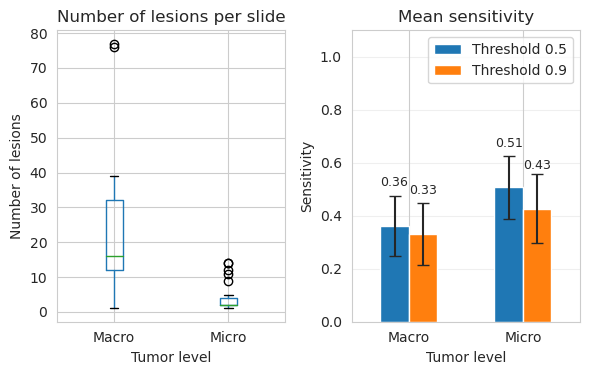

In [7]:
# Plot 1: Number of lesions per slide by tumor level
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Lesion count distribution
tumor_df.boxplot(column='n_lesions', by='level', ax=axes[0])
axes[0].set_title('Number of lesions per slide')
axes[0].set_xlabel('Tumor level')
axes[0].set_ylabel('Number of lesions')
plt.suptitle('')

# Sensitivity comparison with 95% CI
sens_mean = pd.DataFrame({
    'Threshold 0.5': tumor_df.groupby('level')['sensitivity_th0.5'].mean(),
    'Threshold 0.9': tumor_df.groupby('level')['sensitivity_th0.9'].mean()
})
sens_sem = pd.DataFrame({
    'Threshold 0.5': tumor_df.groupby('level')['sensitivity_th0.5'].sem(),
    'Threshold 0.9': tumor_df.groupby('level')['sensitivity_th0.9'].sem()
})
# 95% CI = 1.96 * SEM
sens_ci = sens_sem * 1.96

ax = sens_mean.plot(kind='bar', ax=axes[1], rot=0, yerr=sens_ci, capsize=4)
axes[1].set_title('Mean sensitivity')
axes[1].set_xlabel('Tumor level')
axes[1].set_ylabel('Sensitivity')
axes[1].set_ylim([0, 1.1])
axes[1].legend(title='')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on top of bars (extract from patches directly)
for patch_group in [axes[1].patches[::2], axes[1].patches[1::2]]:  # Separate the two groups
    for patch in patch_group:
        height = patch.get_height()
        axes[1].text(patch.get_x() + patch.get_width()/2., height+0.14,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

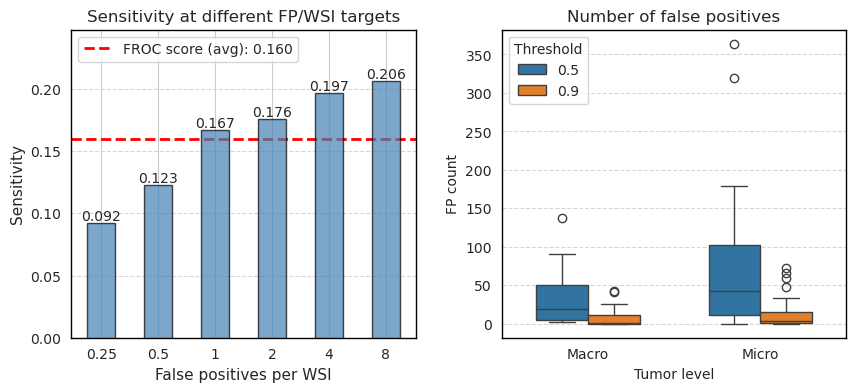

In [23]:
# Plot 2: FROC curve and False positives comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.25)

# Left plot: FROC - Sensitivity at different FP/WSI targets
global_froc = pd.read_csv('localization_score_FROC/global_froc_summary_t5.csv')
fp_targets = [0.25, 0.5, 1, 2, 4, 8]
sensitivities = [
    global_froc['sensitivity_fp_0.25'].values[0],
    global_froc['sensitivity_fp_0.5'].values[0],
    global_froc['sensitivity_fp_1'].values[0],
    global_froc['sensitivity_fp_2'].values[0],
    global_froc['sensitivity_fp_4'].values[0],
    global_froc['sensitivity_fp_8'].values[0]
]

bars = axes[0].bar(range(len(fp_targets)), sensitivities, color='steelblue', alpha=0.7, edgecolor='black', width=0.5, zorder=10)
axes[0].set_xlabel('False positives per WSI', fontsize=11)
axes[0].set_ylabel('Sensitivity', fontsize=11)
axes[0].set_title('Sensitivity at different FP/WSI targets', fontsize=12)
axes[0].set_xticks(range(len(fp_targets)))
axes[0].set_xticklabels(fp_targets)
axes[0].set_ylim([0, max(sensitivities) * 1.2])
axes[0].grid(axis='y', alpha=0.8, zorder=0, linestyle='--')
axes[0].set_axisbelow(True)

# Add value labels on bars
for i, (bar, sens) in enumerate(zip(bars, sensitivities)):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{sens:.3f}', ha='center', va='bottom', fontsize=10)

# Add average line
avg_sens = np.mean(sensitivities)
axes[0].axhline(avg_sens, color='red', linestyle='--', linewidth=2, 
               label=f'FROC score (avg): {avg_sens:.3f}')
axes[0].legend(fontsize=10, loc='upper left')

# Right plot: False positives at both thresholds
fp_data = []
for level in ['Macro', 'Micro']:
    for threshold, col in [('0.5', 'FP_at_th0.5'), ('0.9', 'FP_at_th0.9')]:
        subset = tumor_df[tumor_df['level'] == level][col]
        for val in subset:
            fp_data.append({'Level': level, 'Threshold': threshold, 'FP': val})

fp_df = pd.DataFrame(fp_data)
import seaborn as sns
sns.boxplot(data=fp_df, x='Level', y='FP', hue='Threshold', ax=axes[1], width=0.6)
axes[1].set_title('Number of false positives')
axes[1].set_xlabel('Tumor level')
axes[1].set_ylabel('FP count')
axes[1].legend(title='Threshold', loc='upper left')
axes[1].grid(axis='y', alpha=0.8, linestyle='--')

# Add black borders to both plots
for ax in axes:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.0)

plt.savefig('./results_plots/FROC_and_FP_analysis.pdf', format='pdf', bbox_inches='tight')

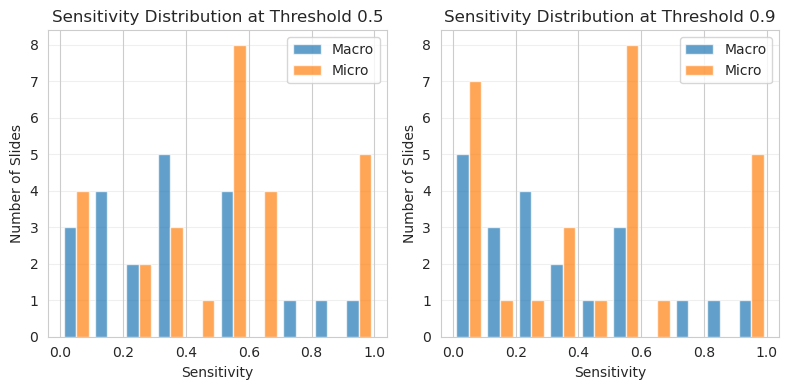

In [26]:
# Plot 3: Sensitivity distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, threshold, col in zip(axes, ['0.5', '0.9'], ['sensitivity_th0.5', 'sensitivity_th0.9']):
    macro_sens = tumor_df[tumor_df['level']=='Macro'][col]
    micro_sens = tumor_df[tumor_df['level']=='Micro'][col]
    
    ax.hist([macro_sens, micro_sens], bins=10, label=['Macro', 'Micro'], alpha=0.7)
    ax.set_xlabel('Sensitivity')
    ax.set_ylabel('Number of Slides')
    ax.set_title(f'Sensitivity Distribution at Threshold {threshold}')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Per-Slide Details

In [27]:
# Show slides with poor detection (sensitivity < 0.5 at threshold 0.5)
poor_detection = tumor_df[tumor_df['sensitivity_th0.5'] < 0.5][[
    'slide', 'level', 'n_lesions', 'TP_at_th0.5', 'FP_at_th0.5', 'sensitivity_th0.5'
]].sort_values('sensitivity_th0.5')

print(f"\nSlides with sensitivity < 0.5 at threshold 0.5: {len(poor_detection)}")
poor_detection


Slides with sensitivity < 0.5 at threshold 0.5: 24


,slide,level,n_lesions,TP_at_th0.5,FP_at_th0.5,sensitivity_th0.5
37,test_099,Micro,1,0,49,0.000000
5,test_011,Micro,1,0,3,0.000000
36,test_097,Micro,1,0,5,0.000000
19,test_052,Micro,1,0,7,0.000000
9,test_026,Macro,76,4,5,0.052632
24,test_068,Macro,16,1,12,0.062500
31,test_082,Macro,77,6,2,0.077922
18,test_051,Macro,39,4,3,0.102564
26,test_071,Macro,37,4,12,0.108108
43,test_113,Macro,17,2,88,0.117647


In [28]:
# Show slides with high false positives (FP > 20 at threshold 0.5)
high_fp = tumor_df[tumor_df['FP_at_th0.5'] > 20][[
    'slide', 'level', 'n_lesions', 'TP_at_th0.5', 'FP_at_th0.5', 'sensitivity_th0.5'
]].sort_values('FP_at_th0.5', ascending=False)

print(f"\nSlides with FP > 20 at threshold 0.5: {len(high_fp)}")
high_fp


Slides with FP > 20 at threshold 0.5: 26


,slide,level,n_lesions,TP_at_th0.5,FP_at_th0.5,sensitivity_th0.5
25,test_069,Micro,11,7,364,0.636364
13,test_033,Micro,2,2,320,1.000000
17,test_048,Micro,12,7,179,0.583333
23,test_066,Micro,5,2,152,0.400000
34,test_092,Micro,2,1,139,0.500000
7,test_016,Macro,20,7,138,0.350000
3,test_008,Micro,2,2,134,1.000000
4,test_010,Micro,2,1,102,0.500000
28,test_074,Micro,2,2,102,1.000000
47,test_122,Micro,14,3,93,0.214286


## 7. Export Summary Results

In [ ]:
# Create summary dataframe for export
export_summary = []
for level in ['Macro', 'Micro']:
    subset = tumor_df[tumor_df['level'] == level]
    total_lesions = subset['n_lesions'].sum()
    
    export_summary.append({
        'Level': level,
        'Num_Slides': len(subset),
        'Total_Lesions': total_lesions,
        'Avg_Lesions_Per_Slide': subset['n_lesions'].mean(),
        'Sensitivity_th0.5': subset['TP_at_th0.5'].sum() / total_lesions,
        'Avg_FP_th0.5': subset['FP_at_th0.5'].mean(),
        'Sensitivity_th0.9': subset['TP_at_th0.9'].sum() / total_lesions,
        'Avg_FP_th0.9': subset['FP_at_th0.9'].mean()
    })

summary_export_df = pd.DataFrame(export_summary)
summary_export_df.to_csv('results_localization_score_FROC/froc_summary_by_level_t5.csv', index=False)
print("Summary saved to: results_localization_score_FROC/froc_summary_by_level_t5.csv")
summary_export_df

## 8. FROC Score Breakdown

In [29]:
# Load global FROC summary
global_froc = pd.read_csv('localization_score_FROC/global_froc_summary_t5.csv')
print("Global FROC Summary:")
print(global_froc)

# Extract sensitivity at each FP/WSI target
fp_targets = [0.25, 0.5, 1, 2, 4, 8]
sensitivities = [
    global_froc['sensitivity_fp_0.25'].values[0],
    global_froc['sensitivity_fp_0.5'].values[0],
    global_froc['sensitivity_fp_1'].values[0],
    global_froc['sensitivity_fp_2'].values[0],
    global_froc['sensitivity_fp_4'].values[0],
    global_froc['sensitivity_fp_8'].values[0]
]

print(f"\nFROC Score: {global_froc['score'].values[0]:.4f}")
print(f"(Average of sensitivities at 6 FP/WSI targets)")


Global FROC Summary:
   run_id     score  sensitivity_fp_0.25  sensitivity_fp_0.5  \
0      48  0.160041             0.092089            0.122595   

   sensitivity_fp_1  sensitivity_fp_2  sensitivity_fp_4  sensitivity_fp_8  
0           0.16705          0.175538          0.196638          0.206338  

FROC Score: 0.1600
(Average of sensitivities at 6 FP/WSI targets)
